# Introduction 
* This code is adapted from the example provided in the python optimal transport package:
https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py

## Imports

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 

import matplotlib.animation as animation
import torch
from torch import nn
import ot


use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

torch.manual_seed(126) 



__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [12]:
sigma = 0.0
n_dims = 2
n_features = 1

# create uniform grid in unit square
def get_data(n_samples):
    c1 = torch.arange(1, n_samples+1) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x


## Plot data



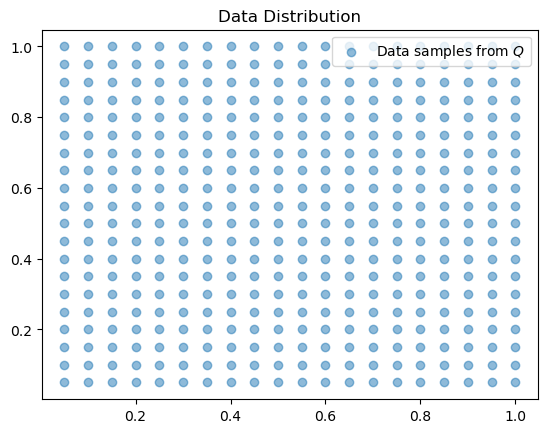

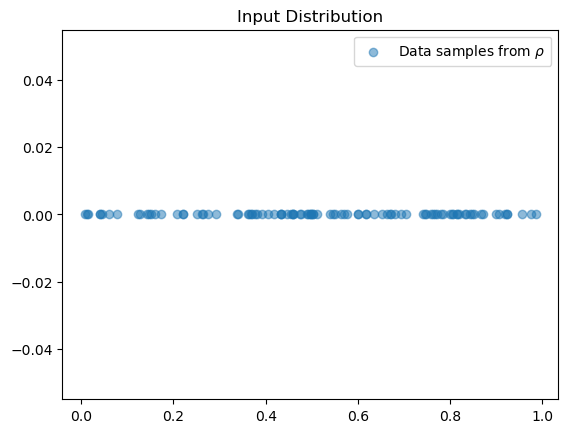

In [13]:
# plot the distributions
x = get_data(20)
plt.figure(1)
plt.scatter(x[:, 0], x[:, 1], label='Data samples from $Q$', alpha=0.5)
plt.title('Data Distribution')
plt.legend()

xn = torch.rand(100, n_features)
yn = torch.zeros(100)
plt.figure(2)
plt.scatter(xn[:, 0],yn, label=r'Data samples from $\rho$', alpha=0.5)
plt.title('Input Distribution')
plt.legend()


## Generator Model



In [14]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 1
        self.n_out = 2
        n= 200
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, self.n_out),
        )

    def forward(self, x):
        x = self.model(x)
        return x        

## Training the model



In [15]:
G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-6)

# number of iteration and size of the batches
n_iter = 750
size_batch = 30 # need to square this to facilitate cartesian product in get_data()

# generate static samples to see their trajectory along training
n_visu = 200
xnvisu = torch.arange(1, n_visu+1).reshape((n_visu, n_features)) / (n_visu)
xvisu = torch.zeros(n_iter, n_visu, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2 
losses = []

# train mode
G.train()

for i in range(n_iter):

    # generate noise samples
    xn = torch.rand(size_batch**2, n_features) # random sample every iteration 
    # xn = torch.arange(1, size_batch+1).reshape((size_batch, n_features)) / (size_batch)

    # generate data samples
    xd = get_data(size_batch) # target data constant across iterations (uniform grid) 

    # generate sample along iterations
    G.eval()
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    G.train()
    xg = G(xn)

    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    if i % 10 == 0:
        print("Iter: {:3d}, loss={}".format(i, losses[-1]))

    loss.backward()
    optimizer.step()

    del M

Iter:   0, loss=0.5525564551353455


Iter:  10, loss=0.1130230724811554
Iter:  20, loss=0.08973633497953415
Iter:  30, loss=0.0957791805267334
Iter:  40, loss=0.0893423929810524
Iter:  50, loss=0.0855417400598526
Iter:  60, loss=0.0852176621556282
Iter:  70, loss=0.0848173275589943
Iter:  80, loss=0.08465714752674103
Iter:  90, loss=0.08425813913345337
Iter: 100, loss=0.08466862887144089
Iter: 110, loss=0.08508225530385971
Iter: 120, loss=0.08354102820158005
Iter: 130, loss=0.08093015104532242
Iter: 140, loss=0.07108873128890991
Iter: 150, loss=0.050506092607975006
Iter: 160, loss=0.037628091871738434
Iter: 170, loss=0.03384517505764961
Iter: 180, loss=0.027309149503707886
Iter: 190, loss=0.022600216791033745
Iter: 200, loss=0.02045656368136406
Iter: 210, loss=0.01850598119199276
Iter: 220, loss=0.017644012346863747
Iter: 230, loss=0.012346618808805943
Iter: 240, loss=0.015941642224788666
Iter: 250, loss=0.014746380038559437
Iter: 260, loss=0.01395225990563631
Iter: 270, loss=0.010035735554993153
Iter: 280, loss=0.0096250

## Plot Loss

Text(0.5, 0, 'Iterations')

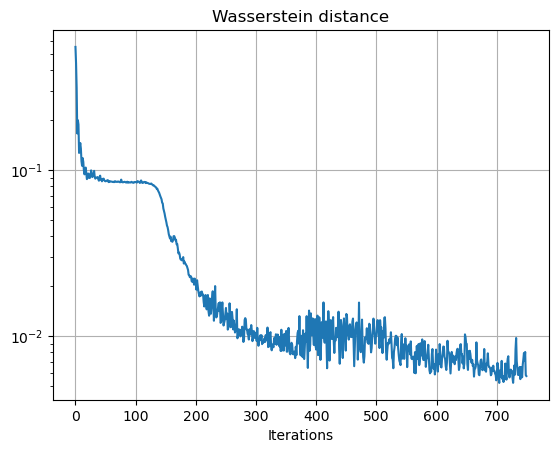

In [16]:
plt.figure(2)
plt.gcf().set_dpi(100) # 300 for paper
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



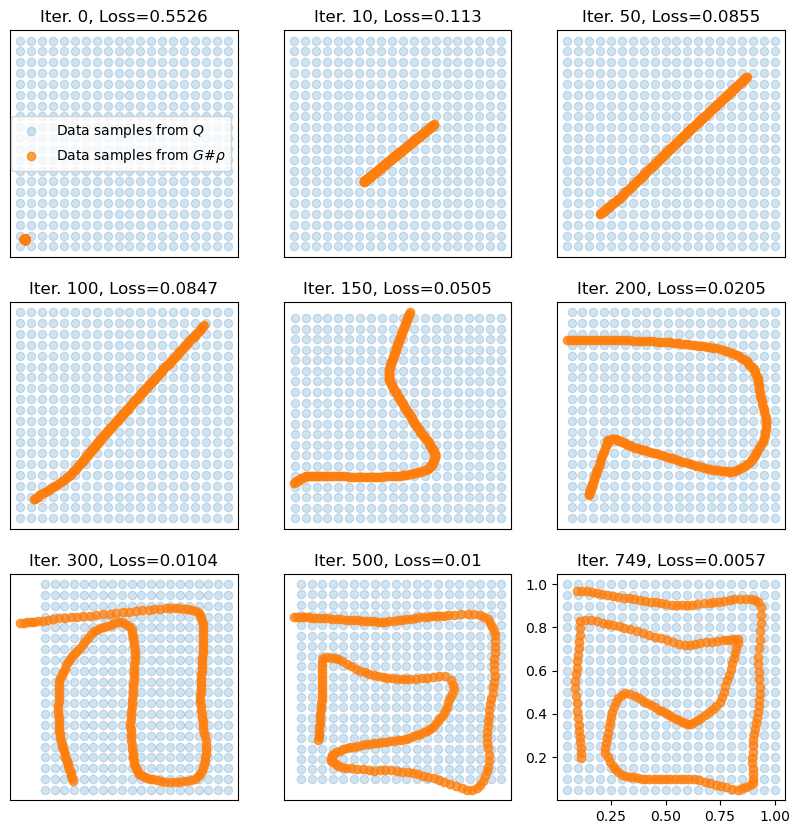

In [17]:
plt.figure(3, (10, 10))
plt.gcf().set_dpi(100) # 200 for paper

ivisu = [0, 10, 50, 100, 150, 200, 300, 500, n_iter-1]

# get input data 
xd = get_data(20)

for i in range(9):
    plt.subplot(3, 3, i + 1)

    # use distances to map to colors
    progression = np.linspace(0, 1, n_visu)  # Normalize progression to [0, 1]
    
    # plot data
    plt.scatter(xd[:, 0], xd[:, 1], label='Data samples from $Q$', alpha=0.2)
    plt.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label=r'Data samples from $G\#\rho$', 
               alpha=.75,
            )
    # only show the axes on the final square 
    if (i != 8):
        plt.xticks(())
        plt.yticks(())
    plt.title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}')
    if i == 0:
        plt.legend()


## Visualize Trajectory - 2x3 

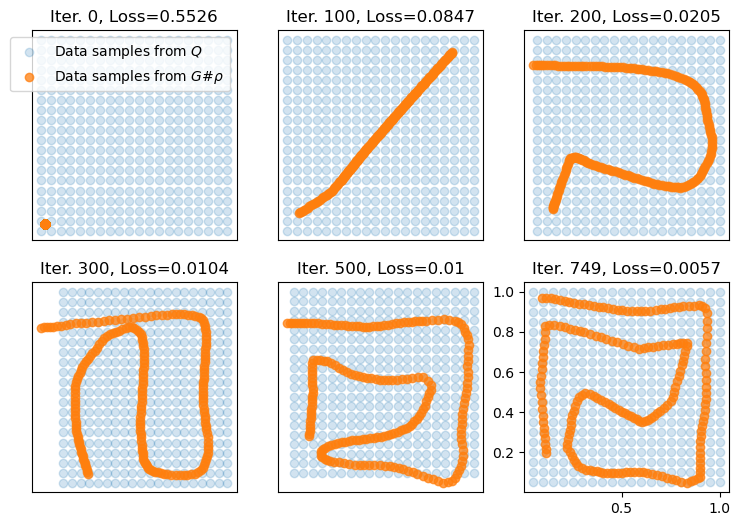

In [18]:
plt.figure(3, (9, 6))
plt.gcf().set_dpi(100) # 200 for paper 

from math import floor 
ivisu = [0, 100, 200, 300, 500, n_iter-1]

xd = get_data(20)
for i in range(6):
    plt.subplot(2, 3, i + 1)

    # use the distances to map to colors (unused)
    progression = np.linspace(0, 1, n_visu)  # normalize to [0, 1]
    
    # plot data 
    plt.scatter(xd[:, 0], xd[:, 1], label='Data samples from $Q$', alpha=0.2)
    plt.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label=r'Data samples from $G\#\rho$', 
               alpha=.75,
                )

    # only show axes on final square 
    if (i != 5):
        plt.xticks(())
        plt.yticks(())
    plt.title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}')
    if i == 0:
        plt.legend()


## Visualize Trajectory - no Axis 

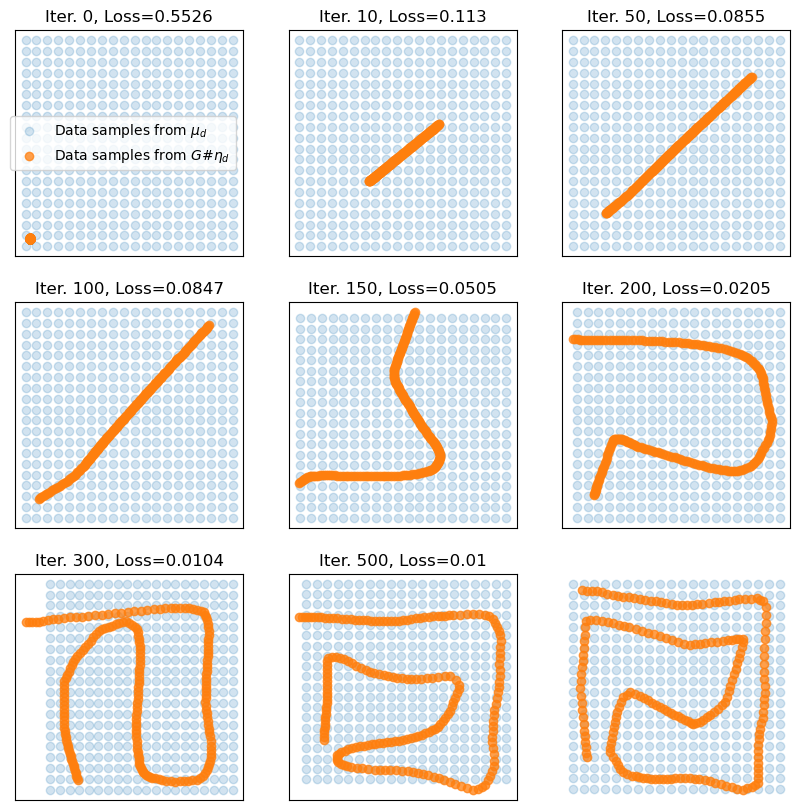

In [19]:
plt.figure(3, (10, 10))

ivisu = [0, 10, 50, 100, 150, 200, 300, 500, n_iter-1]

xd = get_data(20)
plt.gcf().set_dpi(100) # 200 for paper 

for i in range(9):
    plt.subplot(3, 3, i + 1)

    # use the distances to map to colors (unused)
    progression = np.linspace(0, 1, n_visu)  # normalize to [0, 1]
    
    plt.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
    plt.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label='Data samples from $G\#\eta_d$', 
               alpha=.75,
            )

    # only show axes on final square
    if (i != 8):
        plt.xticks(())
        plt.yticks(())
    plt.title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}')
    if i == 0:
        plt.legend()

    if i==8:
        plt.axis('off')
        plt.title('')

## Make Clean Figure for Intro



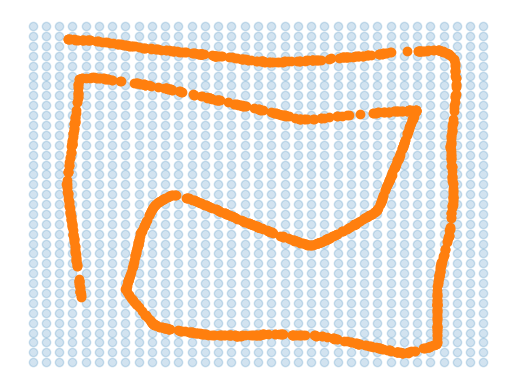

In [20]:
size_batch = 35
xd = get_data(size_batch)
x_curve = torch.rand(size_batch**2, n_features) 
G.eval()
x = G(x_curve).detach().numpy()

plt.figure(5)
plt.gcf().set_dpi(100)

# plot data + NN 
plt.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
plt.scatter(x[:, 0], x[:, 1], label='Data samples from $\mu_d$', alpha=1)# c='orange')

# hide axes 
plt.xticks(())
plt.yticks(())
plt.axis('off')

# Show the plot
plt.show()
